# Reference multiple tissue data to map cell types of multi-batch, external pancreas data
Test for universal cell typing with large reference data (e.g. tabula sapiens) with Cellama
human pancreas with multiple datasets are generated by scIB: 
https://figshare.com/articles/dataset/Benchmarking_atlas-level_data_integration_in_single-cell_genomics_-_integration_task_datasets_Immune_and_pancreas_/12420968

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cellama import (
    lm_cell_reference_celltyping,
    lm_cell_embed,
    lm_cell_integrated_embed
)

In [2]:
adata_ts = sc.read_h5ad('./Tabula_Sapiens_Subsample/Tabula_sapiens_10subsample_raw_counts.h5ad')

In [14]:
cell_type_key = 'celltype'
batch_key = 'tech'
organ_key = 'organ_tissue'

#### Test multiple-tech, samples-based pancreas dataset 
Cell typing only use MULTITISSUE tabula-sapiens data

In [4]:
adata_panc = sc.read_h5ad('./scPancreas/human_pancreas_norm_complexBatch.h5ad')

In [10]:
adata_panc.obs[organ_key] = 'Pancreas'

In [11]:
adata_panc

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'organ_tissue'
    layers: 'counts'

### Dataset Overview - hPancreas

In [12]:
adata_panc.layers["counts"] = adata_panc.X.copy()
sc.pp.normalize_total(adata_panc)
# Logarithmize the data
sc.pp.log1p(adata_panc)
sc.pp.highly_variable_genes(adata_panc, n_top_genes=1500)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [13]:
sc.tl.pca(adata_panc)
sc.pp.neighbors(adata_panc)
sc.tl.umap(adata_panc)


/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

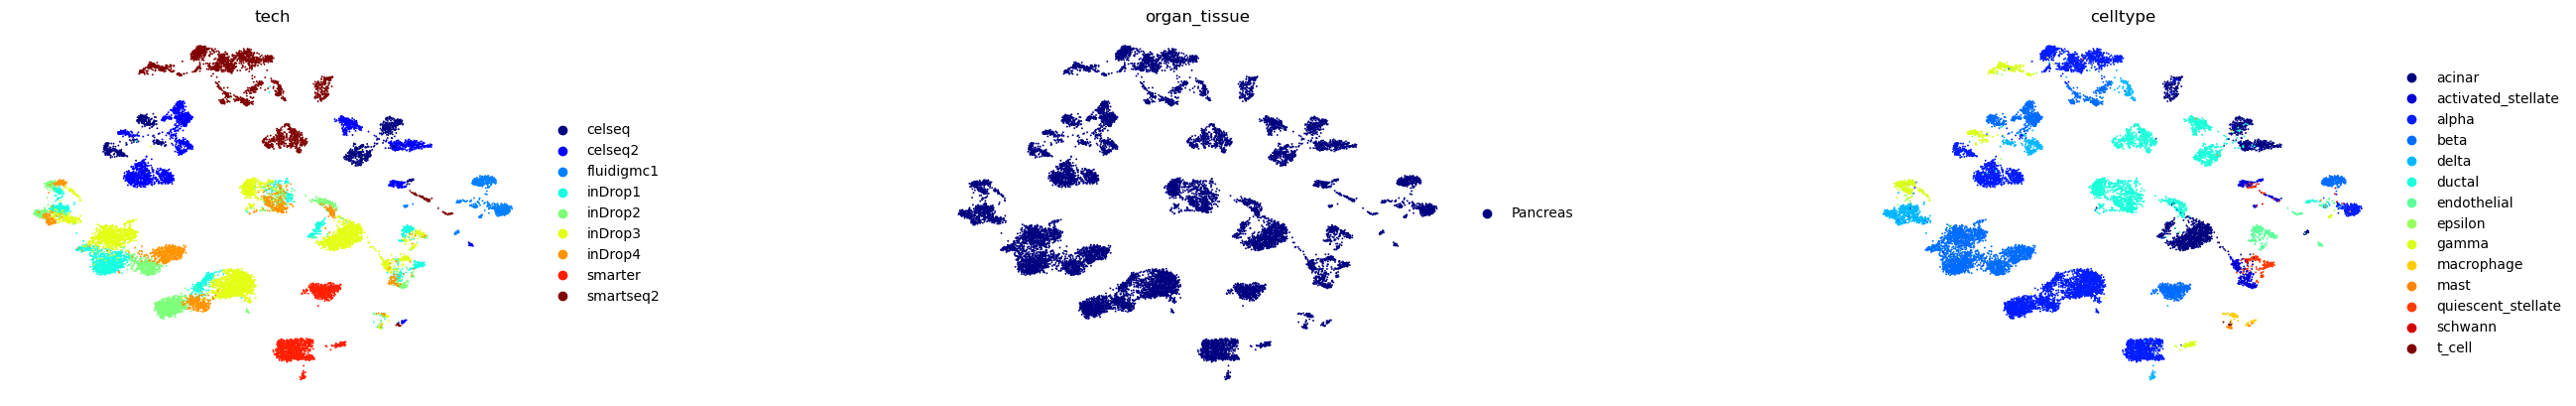

In [15]:
sc.pl.umap(adata_panc, 
           color=[batch_key,organ_key, cell_type_key], 
           frameon=False, 
           wspace=0.6, 
           palette = 'jet',
           title=[batch_key, organ_key,cell_type_key])

### Process Reference Dataset

In [18]:
adata_ts.layers['counts'] = adata_ts.X.copy()

In [19]:
#index to gene name --> for using cellama
adata_ts.var.index = adata_ts.var['feature_name']

In [20]:
#Extract HVGs
sc.pp.normalize_total(adata_ts)
# Logarithmize the data
sc.pp.log1p(adata_ts)
sc.pp.highly_variable_genes(adata_ts, n_top_genes=1500)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [22]:
adata_ref = adata_ts[:,adata_ts.var.highly_variable].copy()

### hPancreas Embedding

In [28]:
adata_panc_ = adata_panc[:,adata_panc.var.highly_variable]

In [31]:
#sentence embedding using HVGs
adata_emb=  lm_cell_embed(adata_panc_, top_k=20, model_name="all-MiniLM-L12-v2",
                          gene_list=None, obs_features= None,
                         return_sentence=True)

/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:95: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_emb = sc.AnnData(emb_res)


/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

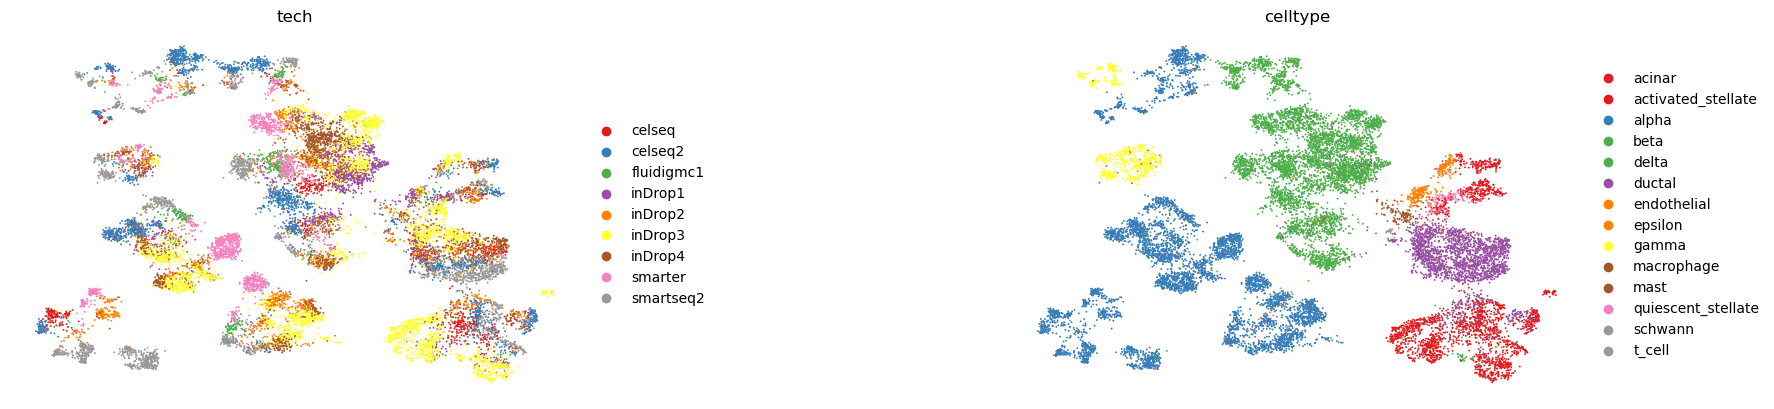

In [34]:
sc.pl.umap(adata_emb, 
           color=[batch_key, cell_type_key], 
           frameon=False, 
           wspace=0.6, 
           palette = 'Set1',
           title=[batch_key, cell_type_key])

### Integration with information of'organ type'

In [60]:
adata_emb, adata_test_emb= lm_cell_integrated_embed(adata_ts, adata_panc_, top_k=20, use_intersect= True,
                                                    model_name='all-MiniLM-L12-v2',obs_features = [organ_key])
#Use hvgs of pancreas and extract these intersected genes from adata_ts to be integrated

Language Model Cell Embedding Is Implemented


/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_value = str(adata.obs[feature][cell_id])
/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:177: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_emb = sc.AnnData(emb_res)
/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:181: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future beha

In [61]:
adata_all =sc.concat(
    [adata_emb, adata_test_emb],
    join='outer', label ='Batch',
)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [62]:
sc.tl.pca(adata_all, svd_solver='arpack')
sc.pp.neighbors(adata_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_all)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

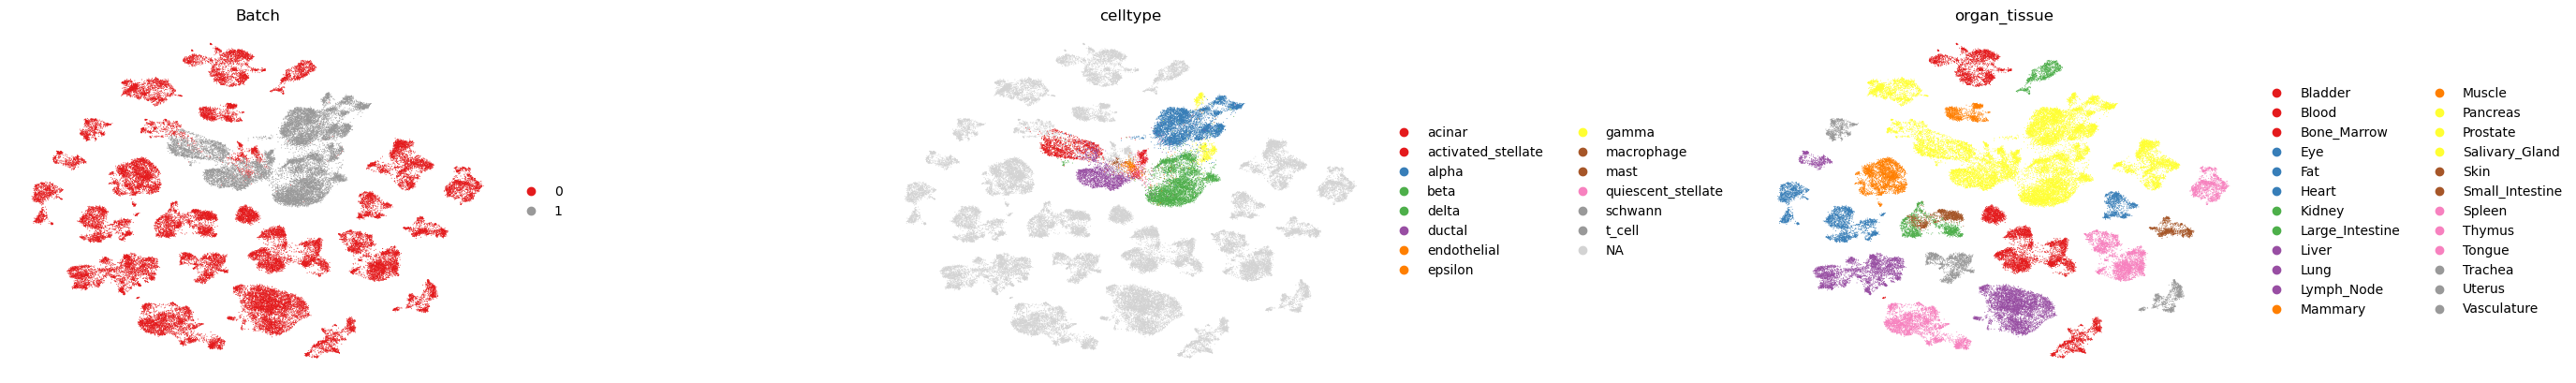

In [63]:
sc.pl.umap(adata_all, 
            frameon=False, 
            wspace=0.6, 
            palette = 'Set1',
            color=['Batch', 'celltype',organ_key])

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action`

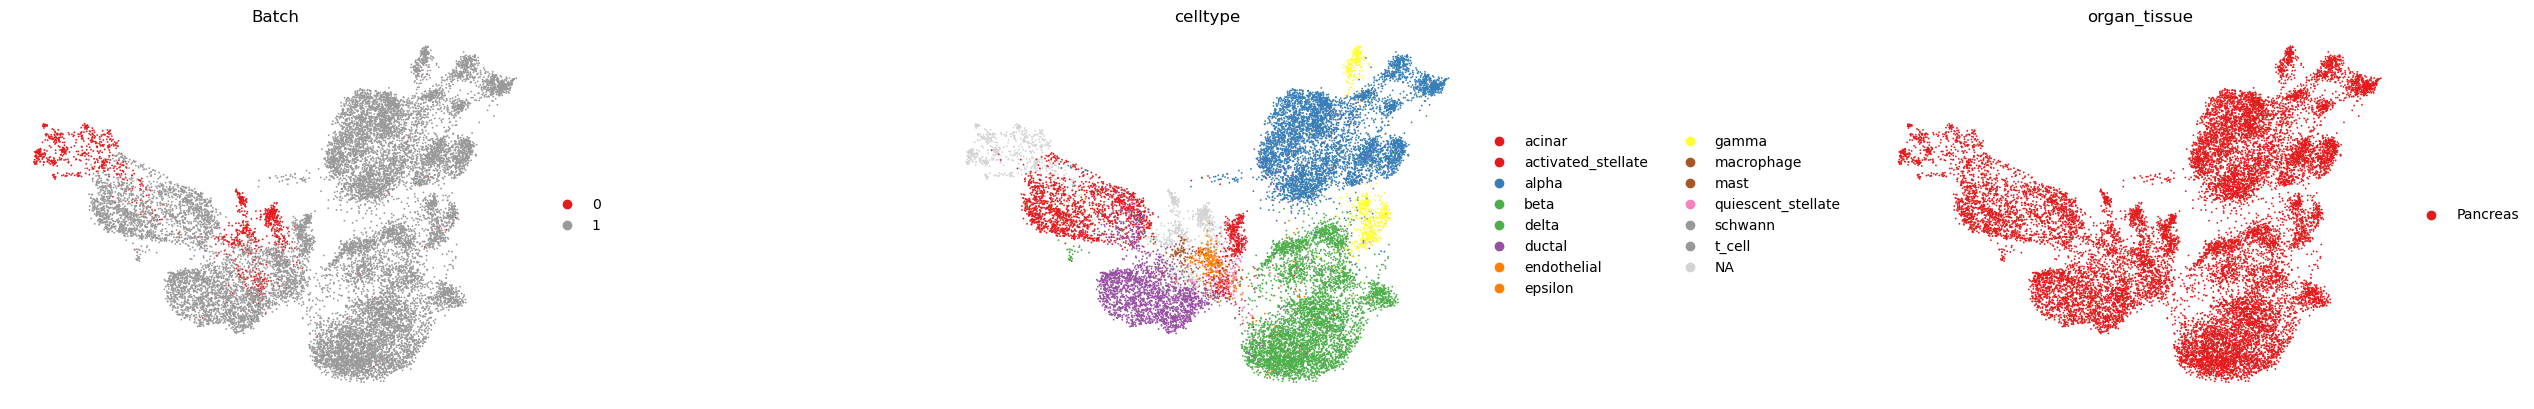

In [64]:
sc.pl.umap(adata_all[adata_all.obs[organ_key]=='Pancreas'], 
            frameon=False, 
            wspace=0.6, 
            palette = 'Set1',
            color=['Batch', 'celltype',organ_key])

In [68]:
adata_ts[adata_ts.obs[organ_key]=='Pancreas'].obs['cell_ontology_class'].value_counts()

cell_ontology_class
pancreatic acinar cell      541
endothelial cell            227
pancreatic ductal cell      222
myeloid cell                181
t cell                       62
pancreatic stellate cell     35
b cell                       17
nk cell                      10
pancreatic pp cell           10
plasma cell                  10
pancreatic beta cell          9
mast cell                     7
pancreatic alpha cell         7
fibroblast                    4
pancreatic delta cell         1
Name: count, dtype: int64

In [91]:
adata_panc.obs[cell_type_key].value_counts()

celltype
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: count, dtype: int64

### Cell Type Mapping using Large, Multi-organ dataset

In [71]:
adata_test_label = lm_cell_reference_celltyping(adata_ts, adata_panc_, 
                                                top_k=20, use_intersect= True,
                                                model_name='all-MiniLM-L12-v2',
                                                ref_cell = 'cell_ontology_class', 
                                                new_name='cell_type_LM',obs_features = [organ_key])


Language Model Cell Embedding Is Implemented


/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_value = str(adata.obs[feature][cell_id])
/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nearest_cell_types = [cell_types[i[0]] for i in indices]


In [72]:
adata_test_label.obs

,tech,celltype,size_factors,organ_tissue,cell_type_LM,cell_type_LM_distance
D101_5,celseq,gamma,0.028492,Pancreas,pancreatic pp cell,0.014389
D101_43,celseq,gamma,0.079348,Pancreas,pancreatic pp cell,0.026486
D101_93,celseq,gamma,0.037932,Pancreas,pancreatic pp cell,0.018874
D102_4,celseq,gamma,0.047685,Pancreas,pancreatic pp cell,0.028297
D172444_23,celseq,gamma,0.038683,Pancreas,pancreatic pp cell,0.024587
...,...,...,...,...,...,...
Sample_1594,smarter,gamma,1.000000,Pancreas,pancreatic pp cell,0.021168
Sample_1595,smarter,gamma,1.000000,Pancreas,pancreatic pp cell,0.017676
Sample_1597,smarter,gamma,1.000000,Pancreas,pancreatic pp cell,0.038752
Sample_1598,smarter,gamma,1.000000,Pancreas,pancreatic alpha cell,0.023943


<Axes: xlabel='celltype', ylabel='cell_type_LM'>

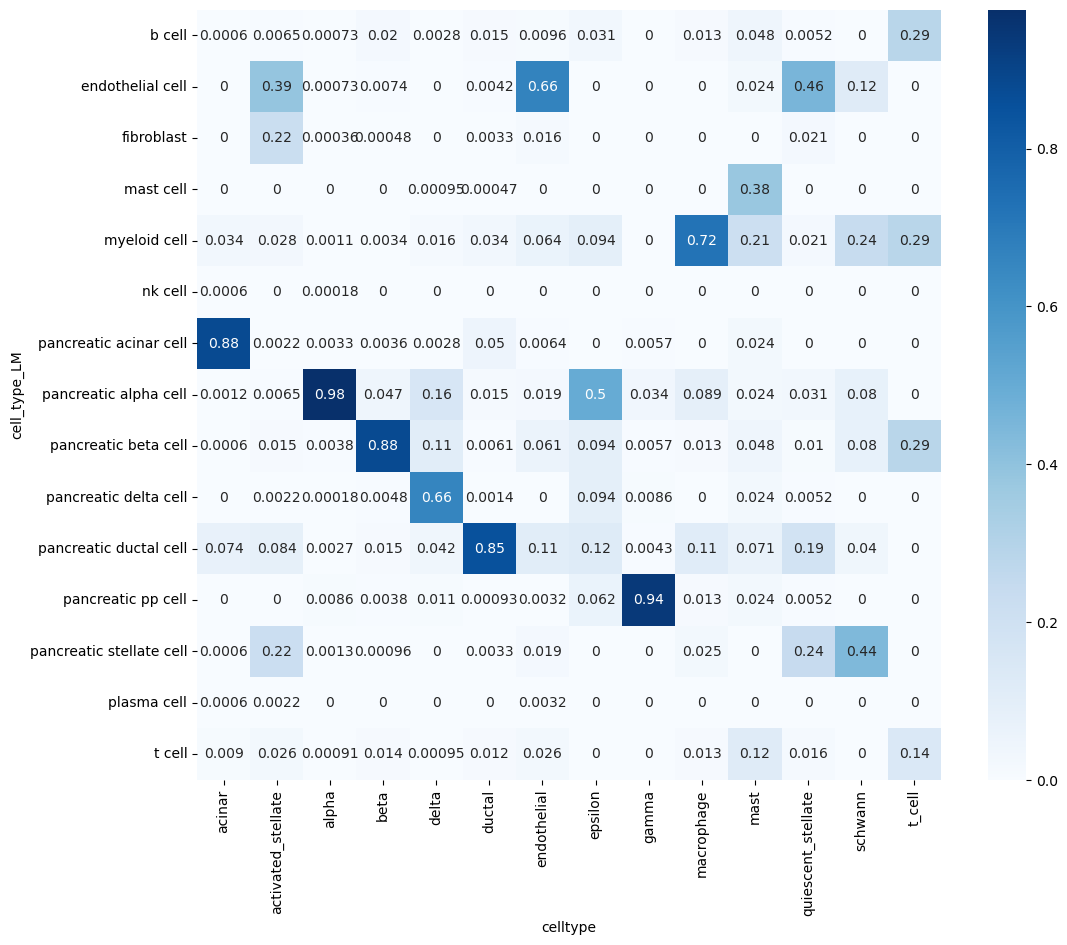

In [75]:
plt.figure(figsize=(12,10))
tmp_crosstab = pd.crosstab(adata_test_label.obs['cell_type_LM'], adata_test_label.obs['celltype'],normalize='columns')
sns.heatmap(tmp_crosstab, cmap='Blues', annot=True)

In [82]:
adata_test_emb.obs['cell_type_LM'] = adata_test_label.obs['cell_type_LM']
adata_test_emb.obs['cell_type_LM_distance'] = adata_test_label.obs['cell_type_LM_distance']

In [83]:
adata_all =sc.concat(
    [adata_emb, adata_test_emb],
    join='outer', label ='Batch',
)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [84]:
sc.tl.pca(adata_all, svd_solver='arpack')
sc.pp.neighbors(adata_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_all)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
 

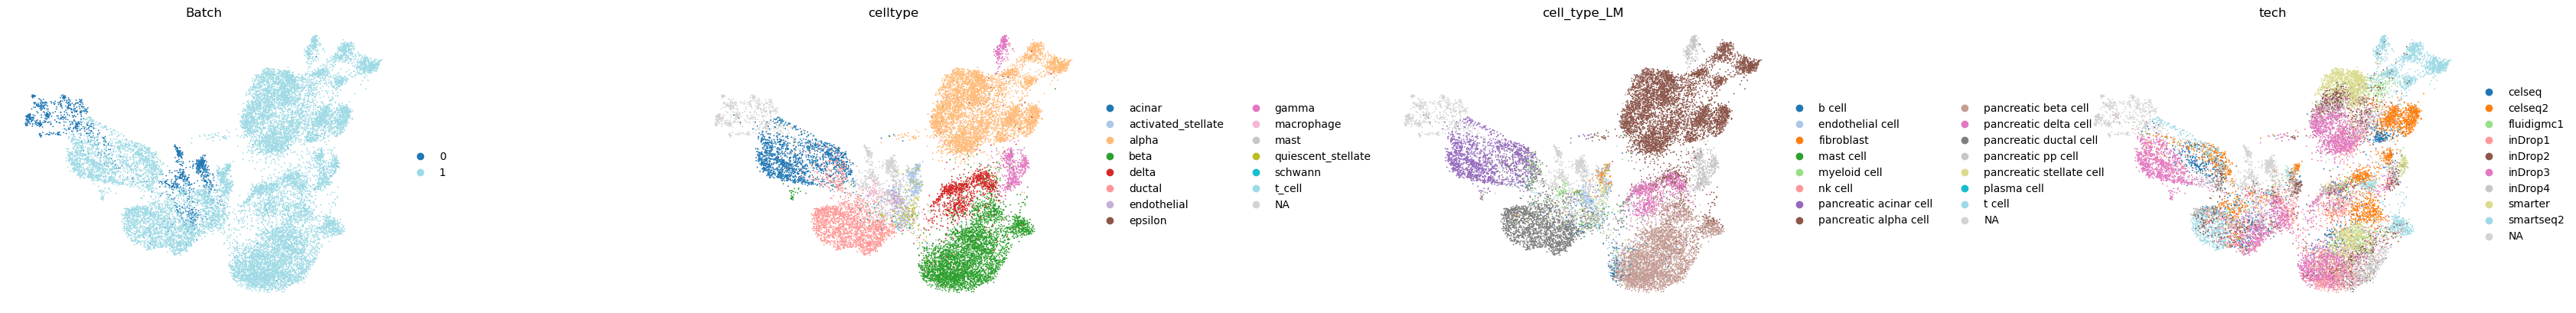

In [90]:
sc.pl.umap(adata_all[adata_all.obs[organ_key]=='Pancreas'], 
            frameon=False, 
            wspace=0.6, 
            palette = 'tab20',
            color=['Batch', 'celltype','cell_type_LM', batch_key])

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


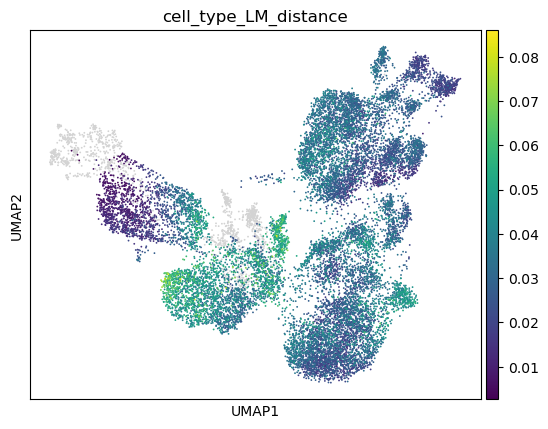

In [86]:
sc.pl.umap(adata_all[adata_all.obs[organ_key]=='Pancreas'], 
            color=['cell_type_LM_distance'])